- добавить комментарии к ячейкам
- оформить все

Задание из видео Карпова [Разбор тестового задания на позицию junior аналитика данных](https://www.youtube.com/watch?v=3VWDh-gdiYg)

Описание данных:  
orders - таблица с информацией о заказах;  
order_id - уникальный идентификатор заказа;  
customer_id - уникальный идентификатор клиента;  
order_date - дата, когда заказ был создан;  
order_amount - cумма заказа;  
platform - платформа, через которую был сделан заказ (например, 'mobile', 'desktop');  
category - категория товара, который был заказан (например, 'smartphones', 'laptops').

1. Построй когортый анализ: выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.  
2. Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.  
3. Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.  

Вывод должен содержать следующие поля:
- дата когорты;
- платформа;
- категория товара;
- размер когорты;
- средний доход с клиента.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(style='whitegrid', palette='pastel')

In [3]:
customer_ids = np.array([])
ids = []
for i in range(1, 1001):
    ids.append(i)
    customer_ids = np.append(customer_ids, np.random.choice(ids, (1, i // 50 + 1)))

In [4]:
customer_ids = customer_ids.astype(int)

In [5]:
# число заказов
N = customer_ids.size

In [6]:
order_dates = pd.date_range('2023-01-01', '2024-02-01', periods=N)

In [7]:
order_amounts = 111 + np.random.exponential(1, N) * 10000

In [8]:
platforms = np.random.choice(['mobile', 'desktop', 'shop'], N, p=[0.5, 0.3, 0.2])

In [9]:
categories = np.random.choice(['smartphones', 'laptops', 'watches'], N, p=[0.5, 0.3, 0.2])

In [10]:
df = pd.DataFrame({
    'order_id': range(1, N + 1), 
    'customer_id': customer_ids, 
    'order_date': order_dates, 
    'order_amount': order_amounts, 
    'platform': platforms, 
    'category': categories
})

In [11]:
df.dtypes

order_id                 int64
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform                object
category                object
dtype: object

In [12]:
df.order_id = df.order_id.astype('int32')

In [13]:
df.platform = df.platform.astype('category')

In [14]:
df.category = df.category.astype('category')

In [15]:
df.dtypes

order_id                 int32
customer_id              int32
order_date      datetime64[ns]
order_amount           float64
platform              category
category              category
dtype: object

In [16]:
# df.to_pickle('data.pkl')

In [16]:
# времядату превращаем в дату
df['order_day'] = df.order_date.dt.to_period('D')

In [17]:
# месяц, в котором совершена первая покупка
df['first_order_month'] = (
    df
    .groupby('customer_id')['order_date']
    .transform('min')
    .dt.to_period('M')
)

In [18]:
# сколько дней прошло с первой покупки
df['day_from_start'] = (
    df['order_day'].astype(int) 
    - df.groupby('customer_id')['order_day'].transform('min').astype(int)
)
df['day_from_start'] = df['day_from_start'].astype('int32')

In [19]:
# доход с покупателя в течение первых 10 дней
df['income_10_days'] = df[df.day_from_start < 10].groupby('customer_id').order_amount.transform(sum)

In [38]:
df.sample(5)

,order_id,customer_id,order_date,order_amount,platform,category,order_day,first_order_month,day_from_start,income_10_days
241,242,116,2023-01-10 01:44:43.487023481,1336.579700,mobile,smartphones,2023-01-10,2023-01,0,43841.620484
2766,2767,354,2023-04-15 03:06:10.643597300,1823.809108,mobile,smartphones,2023-04-15,2023-03,38,NaN
8326,8327,31,2023-11-10 10:36:25.530944008,3415.792035,desktop,laptops,2023-11-10,2023-01,311,NaN
86,87,57,2023-01-04 05:42:06.057610039,549.676357,shop,watches,2023-01-04,2023-01,0,31948.386265
1126,1127,137,2023-02-12 09:20:59.777545394,2835.872366,desktop,smartphones,2023-02-12,2023-02,9,4399.771136


### 1
**Выдели клиентов, совершивших первую покупку в течение определенного месяца (когортную дату) и вычисли размер каждой когорты.**

In [20]:
# размер когорты каждого месяца
cohort_sizes = df.groupby('first_order_month').customer_id.nunique().reset_index()[:12]
cohort_sizes = cohort_sizes.rename(columns={'customer_id': 'cohort_size'})
cohort_sizes

,first_order_month,cohort_size
0,2023-01,214
1,2023-02,111
2,2023-03,89
3,2023-04,82
4,2023-05,59
5,2023-06,65
6,2023-07,51
7,2023-08,65
8,2023-09,46
9,2023-10,50


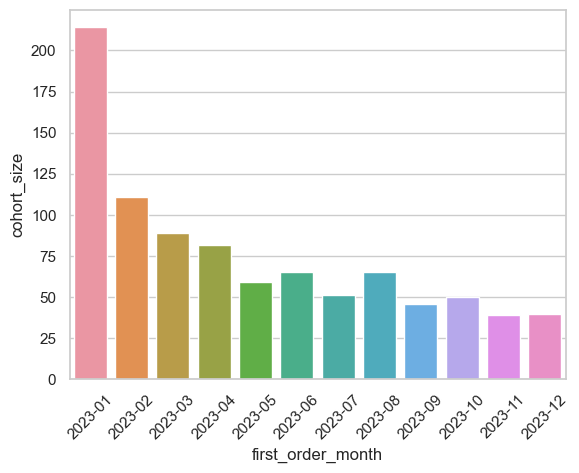

In [21]:
plt.xticks(rotation=45)
sns.barplot(data=cohort_sizes, x='first_order_month', y='cohort_size');

### 2
**Рассчитай средний доход с клиента для каждой когорты за 10 дней с момента их первой покупки.**

In [22]:
incomes_10_days = (
    df
    .groupby(['first_order_month', 'customer_id'])
    .income_10_days
    .min()
    .reset_index()
)
incomes_10_days.sample(5)

,first_order_month,customer_id,income_10_days
153,2023-01,163,9859.672583
365,2023-03,372,3683.459177
212,2023-01,241,2164.720259
909,2023-12,955,4756.172865
63,2023-01,65,44620.593761


In [23]:
mean_user_incomes_10_days = (
    incomes_10_days
    .groupby('first_order_month')
    .agg(
        cohort_size=('customer_id', 'nunique'), 
        mean_user_income_10_days=('income_10_days', 'mean')
    )
    .astype(int)
    .reset_index()
    [:12]
)
mean_user_incomes_10_days

,first_order_month,cohort_size,mean_user_income_10_days
0,2023-01,214,28137
1,2023-02,111,16849
2,2023-03,89,18342
3,2023-04,82,14678
4,2023-05,59,14241
5,2023-06,65,14613
6,2023-07,51,15464
7,2023-08,65,13822
8,2023-09,46,10302
9,2023-10,50,15570


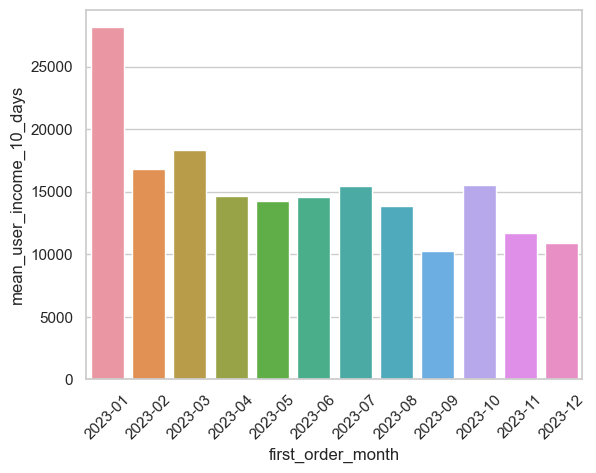

In [24]:
plt.xticks(rotation=45)
sns.barplot(data=mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');
# sns.lmplot(data=mean_user_incomes_10_days, x='first_order_month', y='mean_user_income_10_days');

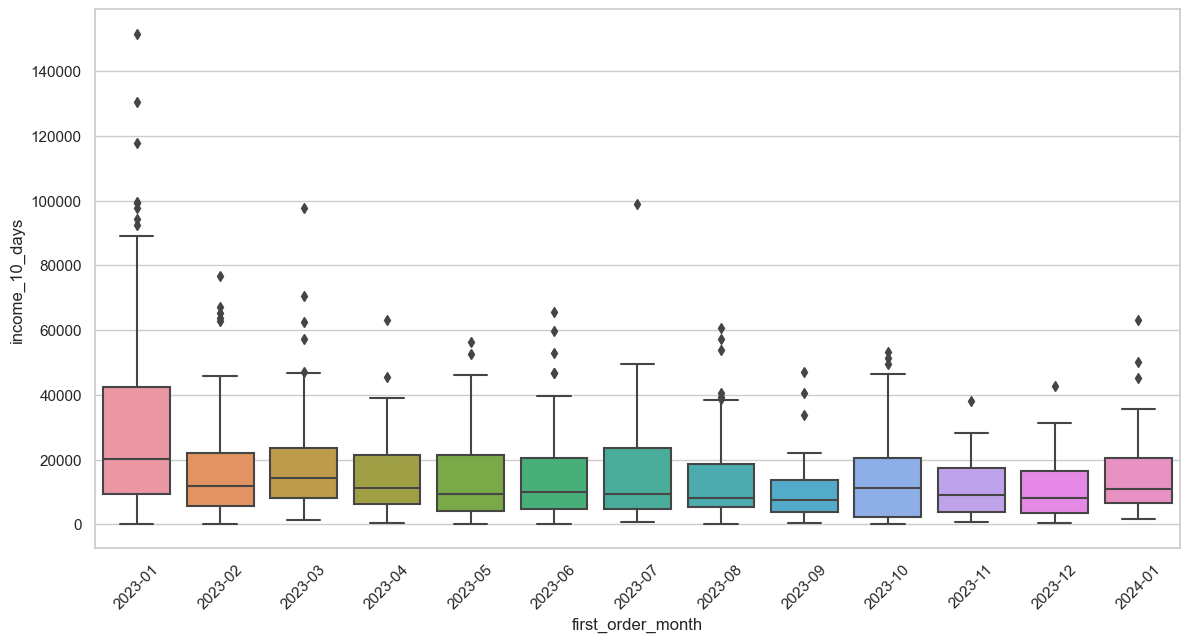

In [25]:
plt.figure(figsize=(14, 7))
plt.xticks(rotation=45)
sns.boxplot(data=incomes_10_days, y='income_10_days', x='first_order_month');

### 3
**Отобрази результаты по месяцам первых покупок, категориям товаров и платформам.**

Посчитаем поюзерное среднее по платформам

In [26]:
#  для каждого пользователя найдем сумму его заказов на каждой платформе
incomes_10_days_by_platform = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'platform'])
    .order_amount
    .sum()
    .reset_index()
)
incomes_10_days_by_platform.columns = ['customer_id', 'platform', 'orders_sum']
incomes_10_days_by_platform.sample(5)

,customer_id,platform,orders_sum
1293,432,desktop,0.000000
576,193,desktop,3781.716407
2625,879,desktop,0.000000
2380,795,mobile,0.000000
1637,546,shop,0.000000


In [28]:
# "словарь" с первыми месяцами для каждого пользователя
first_months = df[df.day_from_start < 10][['customer_id', 'first_order_month']].groupby('customer_id').min()
first_months.sample(5)

,first_order_month
customer_id,
12,2023-01
873,2023-11
344,2023-03
244,2023-02
462,2023-03


In [29]:
# приджойним данные по первым месяцам
incomes_10_days_by_platform_and_first_month = incomes_10_days_by_platform.join(first_months, on='customer_id')
incomes_10_days_by_platform_and_first_month.sample(5)

,customer_id,platform,orders_sum,first_order_month
2154,719,desktop,3038.883111,2023-08
146,49,shop,0.000000,2023-01
2786,938,shop,0.000000,2023-12
483,162,desktop,76792.717543,2023-02
60,21,desktop,3720.373500,2023-01


In [30]:
(
    incomes_10_days_by_platform_and_first_month
    .pivot_table('orders_sum', 'first_order_month', 'platform')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,7680,14370,6087
2023-02,7125,6777,2947
2023-03,5054,10819,2470
2023-04,4035,7591,3053
2023-05,4003,8577,1661
2023-06,4481,6521,3613
2023-07,1412,10372,3680
2023-08,6348,5460,2015
2023-09,2358,6546,1399


Если в расчете среднего дохода с клиента не надо учитывать категории товаров, в которых пользователь не сделал покупок, то поюзерные среднии будут больше:

In [31]:
(
    incomes_10_days_by_platform_and_first_month[incomes_10_days_by_platform_and_first_month.orders_sum!=0]
    .pivot_table('orders_sum', 'first_order_month', 'platform')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

platform,desktop,mobile,shop
first_order_month,,,
2023-01,14545,18526,12174
2023-02,15818,10903,9345
2023-03,11837,15283,11568
2023-04,12253,11527,11921
2023-05,11245,13677,7002
2023-06,10043,12466,11742
2023-07,5144,15113,17063
2023-08,14736,12237,7706
2023-09,7749,12044,8042


Посчитаем поюзерное среднее по категориям товаров

In [32]:
#  для каждого пользователя найдем сумму его заказов по каждой категории товаров
incomes_10_days_by_category = (
    df[df.day_from_start < 10]
    .groupby(['customer_id', 'category'])
    .order_amount
    .sum()
    .reset_index()
)
incomes_10_days_by_category.columns = ['customer_id', 'category', 'orders_sum']
incomes_10_days_by_category.sample(5)

,customer_id,category,orders_sum
983,328,watches,16828.259028
890,297,watches,0.000000
2119,707,smartphones,0.000000
1405,469,smartphones,934.415769
978,327,laptops,0.000000


In [33]:
# приджойним данные по первым месяцам
incomes_10_days_by_category_and_first_month = incomes_10_days_by_category.join(first_months, on='customer_id')
incomes_10_days_by_category_and_first_month.sample(5)

,customer_id,category,orders_sum,first_order_month
2562,857,laptops,0.000000,2023-11
1473,492,laptops,0.000000,2023-04
698,233,watches,0.000000,2023-03
2685,899,laptops,5575.836911,2023-12
392,131,watches,0.000000,2023-01


In [34]:
(
    incomes_10_days_by_category_and_first_month
    .pivot_table('orders_sum', 'first_order_month', 'category')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

category,laptops,smartphones,watches
first_order_month,,,
2023-01,9215,13328,5595
2023-02,4133,9415,3301
2023-03,4286,9648,4408
2023-04,5248,7352,2079
2023-05,3790,7092,3358
2023-06,4272,5522,4819
2023-07,5953,5245,4266
2023-08,5379,5035,3409
2023-09,1372,7086,1845


Если в расчете среднего дохода с клиента не надо учитывать категории товаров, в которых пользователь не сделал покупок, то поюзерные среднии будут больше:

In [35]:
(
    incomes_10_days_by_category_and_first_month[incomes_10_days_by_category_and_first_month.orders_sum!=0]
    .pivot_table('orders_sum', 'first_order_month', 'category')
    .round()
    .astype(int)
    [:12].
    style.background_gradient()
)

category,laptops,smartphones,watches
first_order_month,,,
2023-01,15776,16582,14086
2023-02,9176,13399,10776
2023-03,10310,15901,11540
2023-04,11033,12560,8972
2023-05,10649,10206,14153
2023-06,12073,9204,18427
2023-07,17859,9553,14505
2023-08,12056,9917,13848
2023-09,5259,13581,8487


In [45]:
df.sample(10)

,order_id,customer_id,order_date,order_amount,platform,category,order_day,first_order_month,day_from_start,income_10_days
9018,9019,838,2023-12-06 11:50:04.506131764,6484.700418,desktop,smartphones,2023-12-06,2023-10,44,NaN
367,368,62,2023-01-14 19:35:14.687707957,782.082916,mobile,smartphones,2023-01-14,2023-01,5,15280.526341
4897,4898,401,2023-07-04 08:28:42.140887918,890.207238,mobile,watches,2023-07-04,2023-03,112,NaN
8883,8884,747,2023-12-01 09:51:39.648255540,670.201055,desktop,smartphones,2023-12-01,2023-09,65,NaN
2464,2465,463,2023-04-03 18:14:36.813385303,10610.173253,desktop,smartphones,2023-04-03,2023-04,0,10610.173253
479,480,149,2023-01-19 00:46:49.088316380,323.833920,mobile,smartphones,2023-01-19,2023-01,4,10922.638630
7036,7037,613,2023-09-22 21:04:54.666793424,19472.809056,mobile,smartphones,2023-09-22,2023-07,72,NaN
6585,6586,501,2023-09-05 21:35:59.178629148,5721.741094,desktop,smartphones,2023-09-05,2023-05,103,NaN
8455,8456,840,2023-11-15 07:09:34.617359064,3719.100868,mobile,smartphones,2023-11-15,2023-10,21,NaN
1209,1210,74,2023-02-15 12:20:27.949424850,10433.841219,mobile,watches,2023-02-15,2023-01,40,NaN


In [63]:
df.size

105200